# Setup

In [125]:
import sys
import os
import pickle
sys.path.append('..')

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import scripts.cell_extraction_26N 

import importlib
importlib.reload(scripts.cell_extraction_26N)

<module 'scripts.cell_extraction_26N' from '/Users/emiliolr/Desktop/GTC-OTP/notebooks/../scripts/cell_extraction_26N.py'>

# Reading in RAPID array data in depth-space and plotting

In [3]:
data_home = "/Users/emiliolr/Google Drive/My Drive/GTC"
rapid_depth = xr.open_dataset(os.path.join(data_home, 'rapid_26N', 'moc_vertical.nc'))

rapid_depth

<xarray.Dataset>
Dimensions:              (time: 13057, depth: 307)
Coordinates:
  * time                 (time) datetime64[ns] 2004-04-02 ... 2022-02-15
  * depth                (depth) float64 0.0 19.87 39.74 ... 5.976e+03 5.995e+03
Data variables:
    stream_function_mar  (depth, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

In [4]:
# This temp and salinity data may not be useful for calculating potential density since it's
#   aggregated over longitudes...
rapid_temp_sal = xr.open_dataset(os.path.join(data_home, 'rapid_26N', 'ts_gridded.nc'))
rapid_temp_sal

<xarray.Dataset>
Dimensions:          (time: 13057, depth: 242)
Coordinates:
  * time             (time) datetime64[ns] 2004-04-02 ... 2022-02-15
Dimensions without coordinates: depth
Data variables: (12/19)
    pressure         (depth) float64 ...
    TG_west          (depth, time) float64 ...
    SG_west          (depth, time) float64 ...
    TG_wb3           (depth, time) float64 ...
    SG_wb3           (depth, time) float64 ...
    TG_east          (depth, time) float64 ...
    ...               ...
    TG_east_flag     (depth, time) float64 ...
    SG_east_flag     (depth, time) float64 ...
    TG_marwest_flag  (depth, time) float64 ...
    SG_marwest_flag  (depth, time) float64 ...
    TG_mareast_flag  (depth, time) float64 ...
    SG_mareast_flag  (depth, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

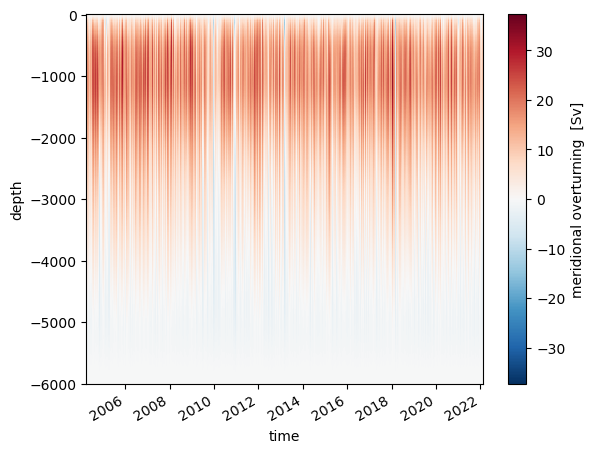

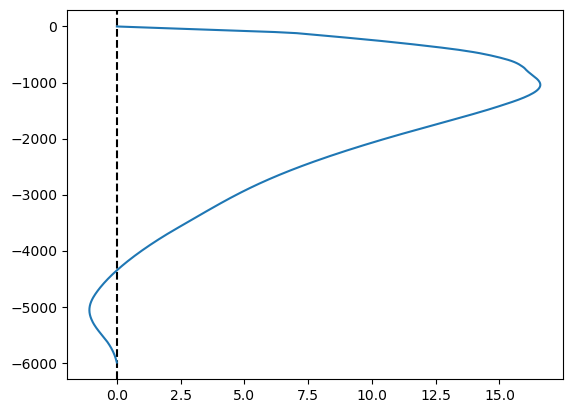

In [5]:
# Pretty sure this is integrating from sea surface down to different depths rather than bottom up...
rapid_flipped = rapid_depth.stream_function_mar.assign_coords({'depth' : -1 * rapid_depth.depth})

rapid_flipped.plot()
plt.show()

plt.axvline(0, color = 'black', linestyle = '--')
plt.plot(rapid_flipped.mean('time'), rapid_flipped.depth)
plt.show()

# Extracting the two cells and the switch point for a 5-month sliding window

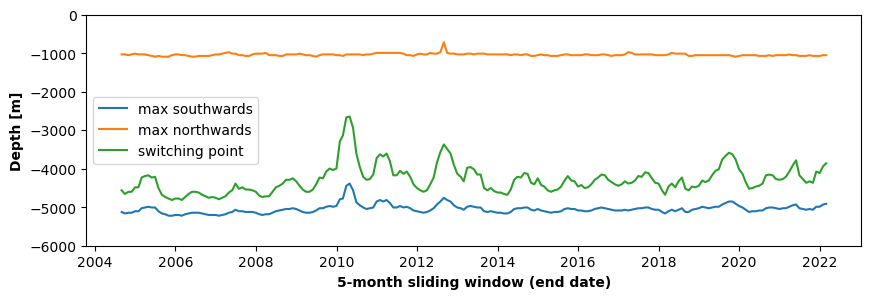

In [126]:
# Calculating the lower/upper cell depths and switch points
min_depths, max_depths, zero_depths, new_time = scripts.cell_extraction_26N.sliding_window_min_max_mix(rapid_flipped)

# Plot these over time--not quite sure how to interpret time dimension because of windows...
plt.figure(figsize = (10, 3))

plt.plot(new_time, min_depths, label = 'max southwards')
plt.plot(new_time, max_depths, label = 'max northwards')
plt.plot(new_time, zero_depths, label = 'switching point')

plt.ylim(-6000, 0)

plt.ylabel('Depth [m]', weight = 'bold')
plt.xlabel('5-month sliding window (end date)', weight = 'bold')

plt.legend();

# Taking a look at the two cells and switch point in ECCO density-space

In [71]:
# Grabbing the time values for ECCO data
time = xr.open_dataset(os.path.join(data_home, 'ecco_data_minimal', '26N.nc')).time.values

In [ ]:
# Grabbing density mappings
with open(os.path.join(data_home, 'ecco_data_minimal', '26N_original_density_range.pickle'), 'rb') as f:
    density_range = pickle.load(f)

In [109]:
# Loading density-space ECCO data
ecco_streamfunction_density_fp = os.path.join(data_home, 'ecco_data_minimal', '26N_streamfunction_density.pickle')

with open(ecco_streamfunction_density_fp, 'rb') as f:
    ecco_streamfunction_density = pickle.load(f)

# Put into an xarray dataset for convenience
ecco_strf = xr.Dataset(data_vars = {'streamfunction' : (['density_layer', 'time'], ecco_streamfunction_density)}, 
                     coords = {'time' : time, 'density_layer' : density_range})

ecco_strf

<xarray.Dataset>
Dimensions:         (density_layer: 100, time: 312)
Coordinates:
  * time            (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T...
  * density_layer   (density_layer) float64 27.82 27.92 28.02 ... 37.63 37.73
Data variables:
    streamfunction  (density_layer, time) float64 6.305 7.511 ... -0.0 -0.0

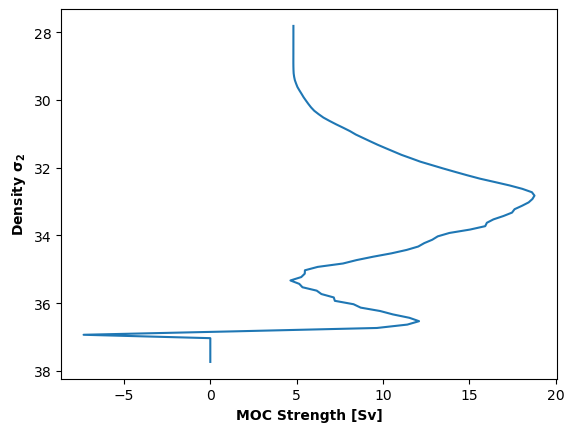

In [110]:
# Plotting streamfunction mean against density layer
plt.plot(ecco_strf.streamfunction.mean('time'), ecco_strf.density_layer)
plt.gca().invert_yaxis()

# plt.ylim(37, 35)

plt.xlabel('MOC Strength [Sv]', weight = 'bold')
plt.ylabel('Density $\\mathbf{\\sigma_2}$', weight = 'bold');

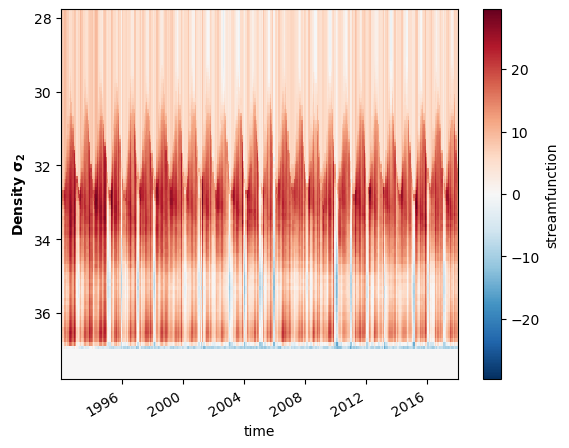

In [104]:
# Plotting streamfunction for density layer vs. time
ecco_strf.streamfunction.plot()
plt.gca().invert_yaxis()

plt.ylabel('Density $\\mathbf{\\sigma_2}$', weight = 'bold');

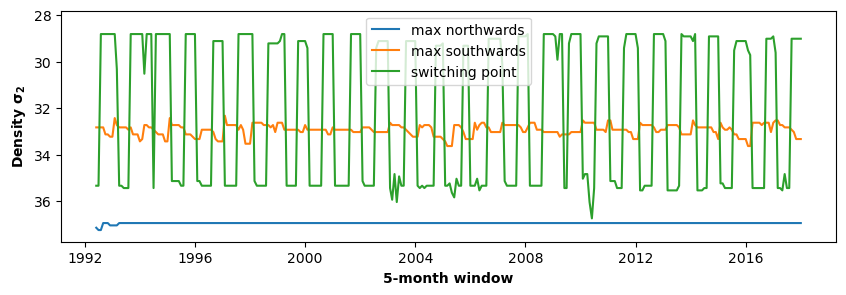

In [130]:
min_depths, max_depths, zero_depths, new_time = scripts.cell_extraction_26N.sliding_window_min_max_mix(ecco_strf.streamfunction, 
                                                                                                       depth_coord_name = 'density_layer', 
                                                                                                       remove_above_depth = None,
                                                                                                       ignore_first_last = 10)

plt.figure(figsize = (10, 3))

plt.plot(new_time, min_depths, label = 'max northwards')
plt.plot(new_time, max_depths, label = 'max southwards')
plt.plot(new_time, zero_depths, label = 'switching point')

plt.ylim(density_range.min(), density_range.max())
plt.gca().invert_yaxis()

plt.ylabel('Density $\\mathbf{\\sigma_2}$', weight = 'bold')
plt.xlabel('5-month window', weight = 'bold')

plt.legend();